In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from scipy.stats import chi2
from numpy.linalg import inv
from scipy.linalg import block_diag
from mobotpy.integration import rk_four
from mobotpy.models import Articulated

In [3]:

# Set the simulation time [s] and the sample period [s]
SIM_TIME = 30.0
T = 0.045

# Create an array of time values [s]
t = np.arange(0.0, SIM_TIME, T)
N = np.size(t)

#distance between the two carts axis and the central axis
a = 1.975
b = 3.850
# VEHICLE SETUP
ell_W_r = ell_W_f = 1.0 #vehicle width

# Set the track length of the vehicle [m]
ell_T_r = b
ell_T_f = a
# Create a vehicle object of type DiffDrive
vehicle = Articulated(ell_W_r, ell_T_r, ell_W_f, ell_T_f)




In [21]:
# CREATE A UKF-BASED ESTIMATOR


def UKF(x, P, v_m, y_m, transm, Q, R, kappa,alpha,beta):

    # Set the augmented state and covariance
    xi = np.append(x, v_m) #augmented vector
    n_x = np.shape(x)[0] #dimension of q
    n_xi = np.shape(xi)[0] #dimension of the augmented vector
    P_xi = block_diag(P, Q) #[[Pk-1^- 0],[0,Q]]
    
    # Define a set of sigma points for for the a priori estimate
    xi_sig = np.zeros((n_xi, 2 * n_xi + 1))

    P_xi_sig = np.linalg.cholesky((n_xi + kappa) * P_xi)

    for i in range(0, n_xi):
        xi_sig[:, i + 1] = xi + P_xi_sig[:, i]
        xi_sig[:, n_xi + i + 1] = xi - P_xi_sig[:, i]

    # Propagate each sigma point through the vehicle's model
    xi_sig_hat = np.zeros((n_xi, 2 * n_xi + 1))
    for i in range(0, 2 * n_xi + 1):
        xi_sig_hat[0:n_x, i] = rk_four(
            vehicle.f, xi_sig[0:n_x, i], xi_sig[n_x:n_xi, i], T
        )

    # Compute the mean and covariance from the transformed sigma points
    w_xi = 0.5 / (n_xi + kappa) * np.ones(2 * n_xi + 1)
    w_xi[0] = 2 * kappa * w_xi[0]
    xi = np.average(xi_sig_hat, axis=1, weights=w_xi)
    P_xi = np.cov(xi_sig_hat, ddof=0, aweights=w_xi)
    
    # Help to keep the covariance matrix symmetrical
    P_xi = (P_xi + np.transpose(P_xi)) / 2

    # Set the vehicle state estimates
    x_hat = xi[0:n_x]
    P_hat = P_xi[0:n_x, 0:n_x]

    # Compute the a posteriori estimate if there are visible features

    # Compute a new set of sigma points using the latest x_hat and P_hat
    x_sig = np.zeros((n_x, 2 * n_x + 1))
    P_sig = np.linalg.cholesky((n_x + kappa) * P_hat)
    for i in range(0, n_x):
        x_sig[:, i + 1] = x_hat + P_sig[:, i]
        x_sig[:, n_x + i + 1] = x_hat - P_sig[:, i]
    
    m_k = np.shape(transm)[1]
    # Find the expected measurement corresponding to each sigma point
    y_hat_sig = np.zeros(( m_k, 2 * n_x + 1))
    for j in range(0, 2 * n_x + 1):
        # Compute the expected measurements
        for i in range(0, m_k):
            r = np.sqrt(
                (transm[0, i] - x_sig[0, j]) ** 2
                + (transm[1, i] - x_sig[1, j]) ** 2
            )
            y_hat_sig[i, j] = alpha*np.exp(-beta*r)


    # Recombine the sigma points
    w_x = 0.5 / (n_x + kappa) * np.ones(2 * n_x + 1)
    w_x[0] = 2 * kappa * w_x[0]
    y_hat = np.average(y_hat_sig, axis=1, weights=w_x)
    P_y = np.zeros((m_k, m_k))
    P_xy = np.zeros((n_x,m_k))
    for i in range(0, 2 * n_x + 1):
        y_diff = y_hat_sig[:, i] - y_hat
        x_diff = x_sig[:, i] - x_hat
        P_y = P_y + w_x[i] * (y_diff.reshape(( m_k, 1))) @ np.transpose(
            y_diff.reshape((m_k, 1))
        )
        P_xy = P_xy + w_x[i] * (x_diff.reshape((n_x, 1))) @ np.transpose(
            y_diff.reshape((m_k, 1))
        )
    P_y = P_y + np.kron(np.identity(m_k), R)

    # Help to keep the covariance matrix symmetrical
    P_y = (P_y + np.transpose(P_y)) / 2

    # Update the estimate
    K = P_xy @ inv(P_y)
    x_hat = x_hat + K @ (y_m - y_hat)
    P_hat = P_hat - K @ P_y @ np.transpose(K)
    print(P_hat)
    # Help keep the covariance matrix symmetric
    P_hat = (P_hat + np.transpose(P_hat)) / 2

    return x_hat, P_hat

In [18]:
# Create a range and bearing sensor model
def transmitter_sensor(x, transm, R, alpha, beta):
    #x is the vector with the vehicle coordinates
    #transm is the vector with each transmitter's location
    # Define how many total features are available
    #m = np.shape(transm)[1]


    m_k = np.shape(transm)[1]
    y = np.zeros(m_k)

        # Compute the range and bearing to all features (including sensor noise)
    for i in range(0, m_k):
        # Range measurement [m]
        r = np.sqrt((transm[0, i] - x[0]) ** 2 + (transm[1, i] - x[1]) ** 2)
        y[i] = alpha*np.exp(-beta*r) + np.sqrt(R[0, 0]) * np.random.randn(1)


    # Return the range and bearing to features in y with indices in a
    return y


In [22]:
# SIMULATE THE SYSTEM
S_v = 0.025
S_phi = 2*0.018/T
S_r = 0.23
# Number of transmitters
m = 2
#m = 2 #number of transmitters
# Set the covariance matrices
Q = np.diag([S_v ** 2, S_phi ** 2])
R = np.diag([S_r ** 2])

#sensors
alpha=12
beta=0.03


# Map size [m]
D_MAP = 10
m = 7
# Randomly place features in the map
transmit = np.zeros((2,m))
for i in range(0, m):
   transmit[:, i] = D_MAP * (2.0 * np.random.rand(1) - 1.0)

# Initialize state, input, and estimator variables
x = np.zeros((4, N))
v_m = np.zeros((2, N))
x_hat_UKF = np.zeros((4, N))
P_hat_UKF = np.zeros((4, 4, N))

# Initialize the state
x_init = np.zeros(4)

# Set the initial guess of the estimator
x_guess = x_init + np.array([0.5, 15.5, 0.5, 1])
P_guess = np.diag(np.square([0.5, 15.5, 1, 1]))
P_xi_ = block_diag(P_guess,Q) #[[Pk-1^- 0],[0,Q]]

# Define a set of sigma points for for the a priori estimate

# Set the initial conditions
x[:, 0] = x_init
v_m[:, 0] = np.zeros(2)
x_hat_UKF[:, 0] = x_guess
P_hat_UKF[:, :, 0] = P_guess

KAPPA = 5 - np.shape(x)[0]

for i in range(1, N):

    # Compute some inputs (i.e., drive around)
    v = np.array([0, 0])

    # Run the vehicle motion model
    x[:, i] = rk_four(vehicle.f, x[:, i - 1], v, T)

    # Model the rate sensors
    v_m[0, i] = v[0] + np.sqrt(Q[0, 0]) * np.random.randn(1)
    v_m[1, i] = v[1] + np.sqrt(Q[1, 1]) * np.random.randn(1)

    # Run the measurement model
    y_m = transmitter_sensor(x[:, i], transmit, R, alpha,beta)

    # Run the UKF estimator
    x_hat_UKF[:, i], P_hat_UKF[:, :, i] = UKF(
        x_hat_UKF[:, i - 1],
        P_hat_UKF[:, :, i - 1],
        v_m[:, i - 1],
        y_m,
        transmit,
        Q,
        R,
        KAPPA,
        alpha,
        beta
    )


[[ 0.22285843 -1.54808835 -0.01151341 -0.02301796]
 [-1.54808835 -1.4303354  -1.09692328 -2.19296777]
 [-0.01151341 -1.09692328  0.99898005 -0.00261461]
 [-0.02301796 -2.19296777 -0.00261461  0.99403885]]


LinAlgError: Matrix is not positive definite

/tmp/ipykernel_14550/1941051028.py:26: RuntimeWarning: invalid value encountered in sqrt
  sigma[1, :] = np.sqrt(s1 * P_hat_UKF[1, 1, :])


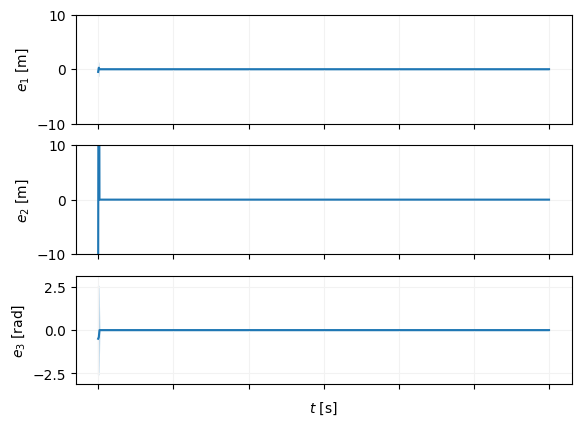

In [15]:
# PLOT THE SIMULATION OUTPUTS

# Find the scaling factors for covariance bounds
alpha = 0.01
s1 = chi2.isf(alpha, 1)
s2 = chi2.isf(alpha, 2)

# Set some plot limits for better viewing
x_range = 10
y_range = 10
theta_range = 3.14
phi_range = 3.14

# Plot the errors with covariance bounds
sigma = np.zeros((3, N))
fig1 = plt.figure(1)
ax1 = plt.subplot(311)
sigma[0, :] = np.sqrt(s1 * P_hat_UKF[0, 0, :])
plt.fill_between(t, -sigma[0, :], sigma[0, :], color="C0", alpha=0.2)
plt.plot(t, x[0, :] - x_hat_UKF[0, :], "C0")
plt.ylabel(r"$e_1$ [m]")
plt.setp(ax1, xticklabels=[])
ax1.set_ylim([-x_range, x_range])
plt.grid(color="0.95")
ax2 = plt.subplot(312)
sigma[1, :] = np.sqrt(s1 * P_hat_UKF[1, 1, :])
plt.fill_between(t, -sigma[1, :], sigma[1, :], color="C0", alpha=0.2)
plt.plot(t, x[1, :] - x_hat_UKF[1, :], "C0")
plt.ylabel(r"$e_2$ [m]")
plt.setp(ax2, xticklabels=[])
ax2.set_ylim([-y_range, y_range])
plt.grid(color="0.95")
ax3 = plt.subplot(313)
sigma[2, :] = np.sqrt(s1 * P_hat_UKF[2, 2, :])
plt.fill_between(t, -sigma[2, :], sigma[2, :], color="C0", alpha=0.2)
plt.plot(t, x[2, :] - x_hat_UKF[2, :], "C0")
plt.ylabel(r"$e_3$ [rad]")
plt.setp(ax3, xticklabels=[])
ax3.set_ylim([-theta_range, theta_range])
plt.xlabel(r"$t$ [s]")
plt.grid(color="0.95")

NameError: name 'R_MAX' is not defined

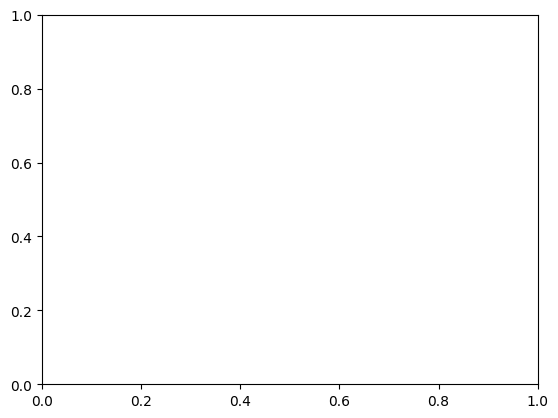

In [34]:
# Plot the actual versus estimated positions on the map
fig2, ax = plt.subplots()
circle = Circle(x[0:2, 0], radius=R_MAX, alpha=0.2, color="C0", label="Sensing range")
ax.add_artist(circle)
plt.plot(x[0, :], x[1, :], "C0", label="Actual")
plt.plot(x_hat_UKF[0, :], x_hat_UKF[1, :], "C1--", label="Estimated")
plt.plot(transmit[0, :], transmit[1, :], "C2*", label="Transmitter")
plt.axis("equal")
ax.set_xlim([np.min(x_hat_UKF[0, :]) - 10, np.max(x_hat_UKF[0, :]) + 10])
ax.set_ylim([np.min(x_hat_UKF[1, :]) - 10, np.max(x_hat_UKF[1, :]) + 10])
plt.xlabel(r"$x_1$ [m]")
plt.ylabel(r"$x_2$ [m]")
plt.grid(color="0.95")
plt.legend()

# Show the plot to the screen
plt.show()